aggregator_parallel - ppo: Experiment Start Time: 2024-10-25 05:06:47
aggregator_parallel - ppo: 过滤前行数: 1366
aggregator_parallel - ppo: 过滤后行数: 1362
aggregator_parallel - ppo: 平均 Latency = 190.25 ms
aggregator_parallel - dqn: Experiment Start Time: 2024-10-25 05:14:15
aggregator_parallel - dqn: 过滤前行数: 1219
aggregator_parallel - dqn: 过滤后行数: 1215
aggregator_parallel - dqn: 平均 Latency = 214.63 ms
aggregator_parallel - cloud: Experiment Start Time: 2024-10-25 06:06:56
aggregator_parallel - cloud: 过滤前行数: 1211
aggregator_parallel - cloud: 过滤后行数: 1206
aggregator_parallel - cloud: 平均 Latency = 217.40 ms
aggregator_parallel - edge: Experiment Start Time: 2024-10-25 06:14:15
aggregator_parallel - edge: 过滤前行数: 1204
aggregator_parallel - edge: 过滤后行数: 1204
aggregator_parallel - edge: 平均 Latency = 219.63 ms
aggregator_parallel - all: Experiment Start Time: 2024-10-25 05:59:37
aggregator_parallel - all: 过滤前行数: 1197
aggregator_parallel - all: 过滤后行数: 1195
aggregator_parallel - all: 平均 Latency = 225.76 m

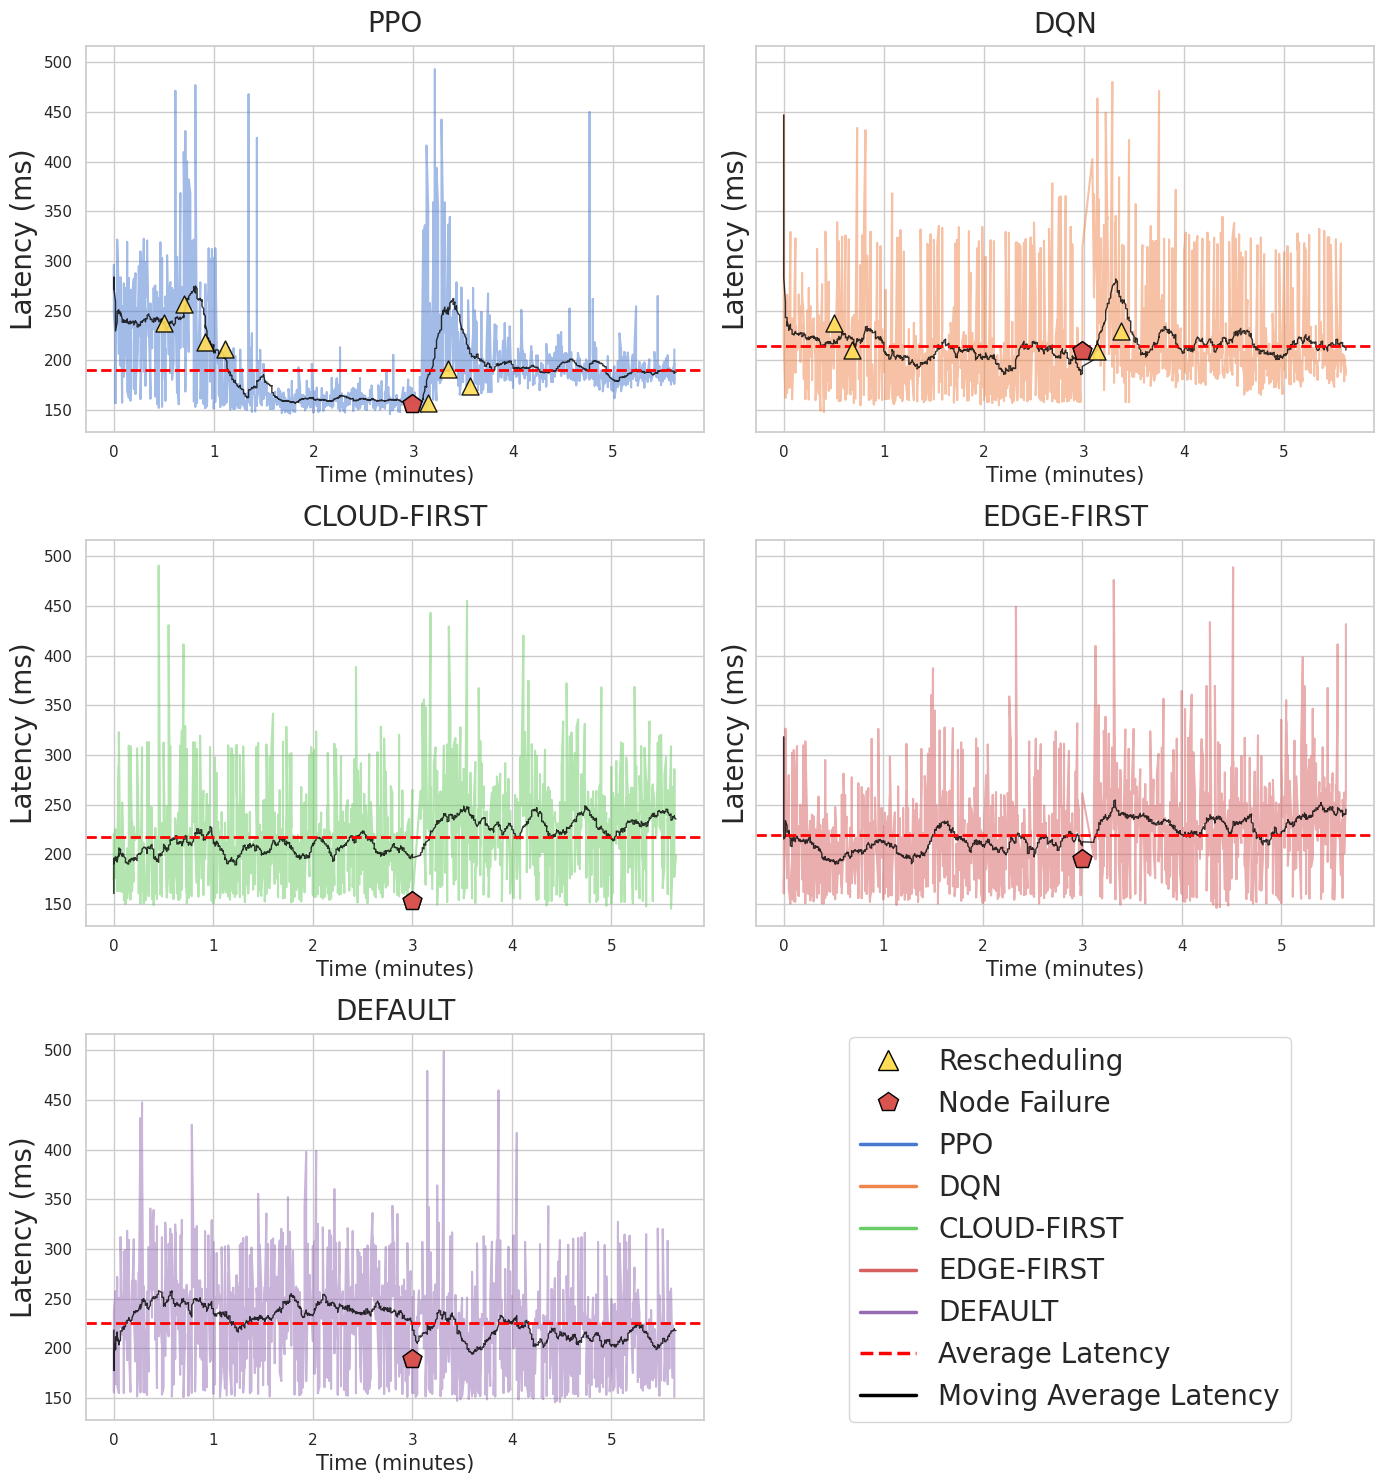

aggregator_sequential - ppo: Experiment Start Time: 2024-10-25 05:36:41
aggregator_sequential - ppo: 过滤前行数: 1168
aggregator_sequential - ppo: 过滤后行数: 1164
aggregator_sequential - ppo: 平均 Latency = 220.01 ms
aggregator_sequential - dqn: Experiment Start Time: 2024-10-25 05:44:11
aggregator_sequential - dqn: 过滤前行数: 1114
aggregator_sequential - dqn: 过滤后行数: 1111
aggregator_sequential - dqn: 平均 Latency = 241.28 ms
aggregator_sequential - cloud: Experiment Start Time: 2024-10-25 06:28:52
aggregator_sequential - cloud: 过滤前行数: 1035
aggregator_sequential - cloud: 过滤后行数: 1031
aggregator_sequential - cloud: 平均 Latency = 264.43 ms
aggregator_sequential - edge: Experiment Start Time: 2024-10-25 06:36:11
aggregator_sequential - edge: 过滤前行数: 1021
aggregator_sequential - edge: 过滤后行数: 1013
aggregator_sequential - edge: 平均 Latency = 265.54 ms
aggregator_sequential - all: Experiment Start Time: 2024-10-25 06:21:34
aggregator_sequential - all: 过滤前行数: 1031
aggregator_sequential - all: 过滤后行数: 1026
aggregator

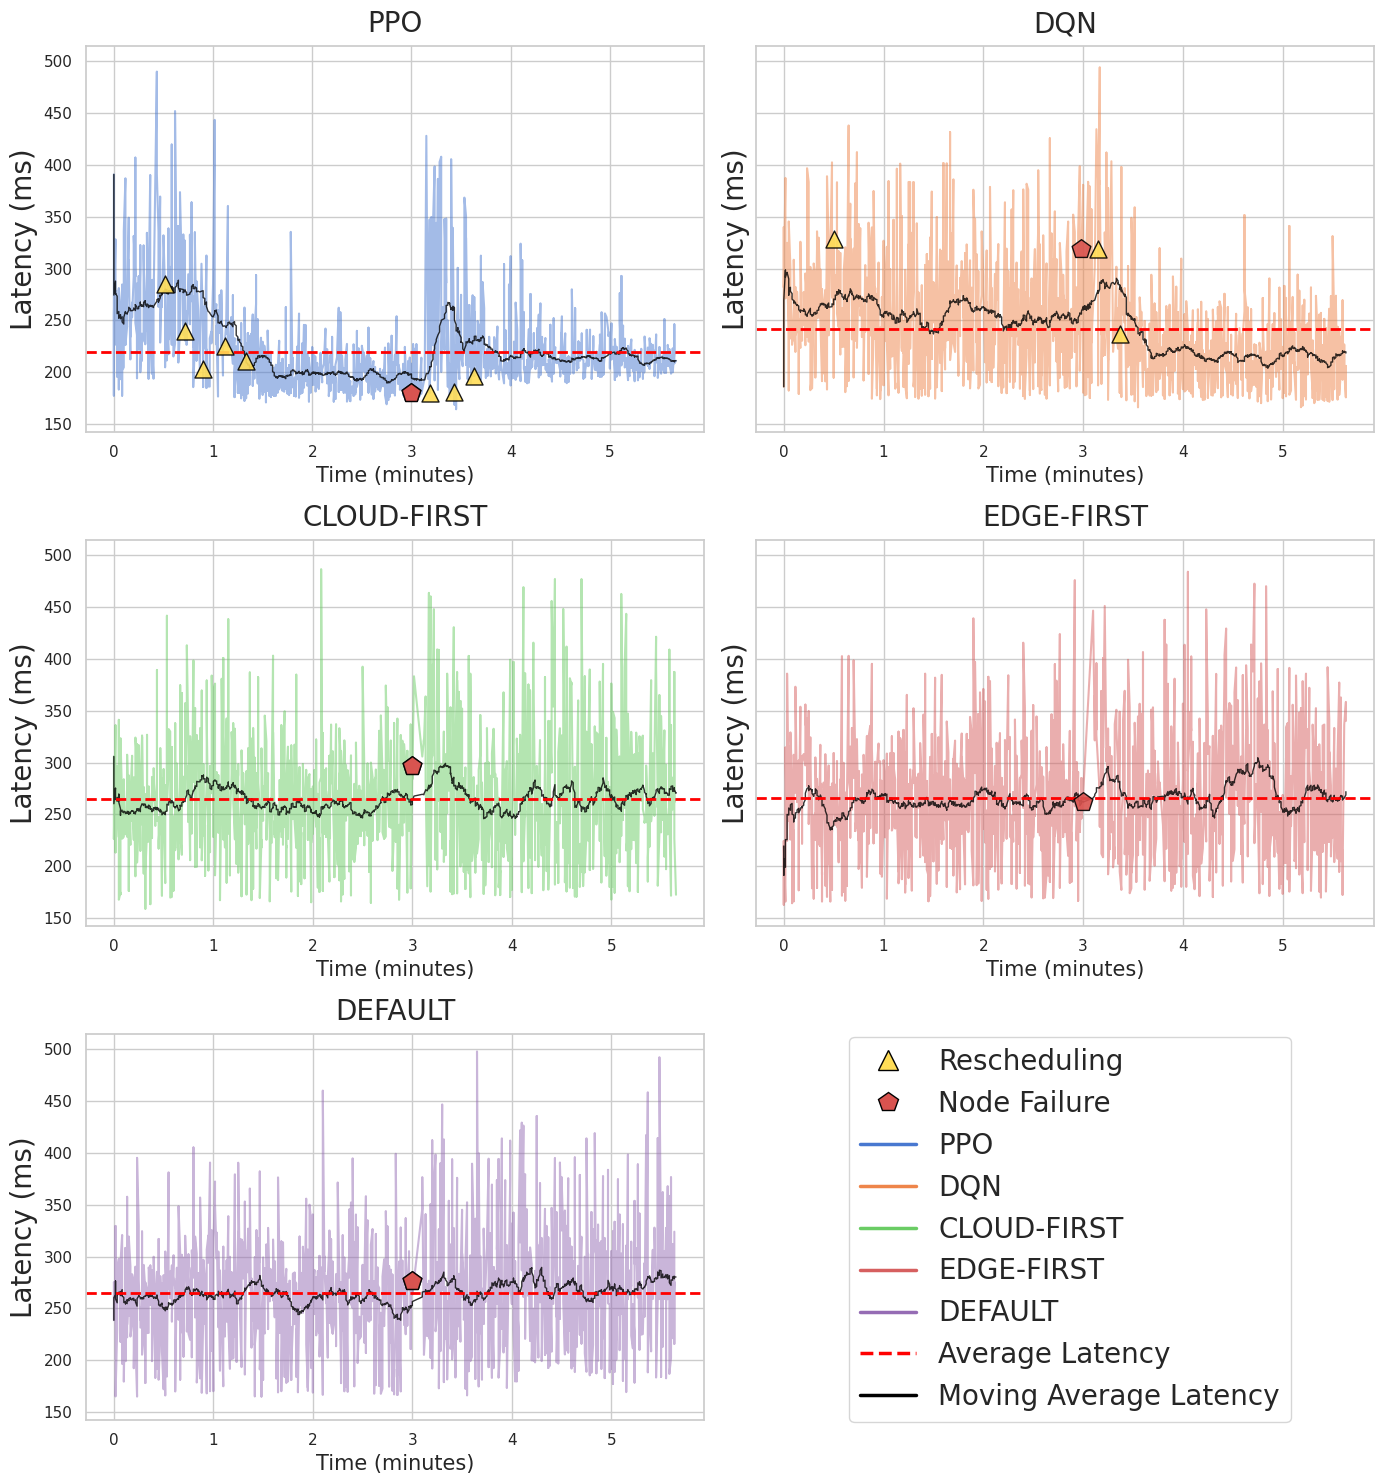

chain - ppo: Experiment Start Time: 2024-10-25 10:39:27
chain - ppo: 过滤前行数: 1243
chain - ppo: 过滤后行数: 1233
chain - ppo: 平均 Latency = 215.98 ms
chain - dqn: Experiment Start Time: 2024-10-25 10:47:02
chain - dqn: 过滤前行数: 1161
chain - dqn: 过滤后行数: 1148
chain - dqn: 平均 Latency = 234.76 ms
chain - cloud: Experiment Start Time: 2024-10-25 09:24:54
chain - cloud: 过滤前行数: 1004
chain - cloud: 过滤后行数: 991
chain - cloud: 平均 Latency = 274.11 ms
chain - edge: Experiment Start Time: 2024-10-25 09:32:19
chain - edge: 过滤前行数: 1040
chain - edge: 过滤后行数: 1036
chain - edge: 平均 Latency = 263.28 ms
chain - all: Experiment Start Time: 2024-10-25 09:17:33
chain - all: 过滤前行数: 1061
chain - all: 过滤后行数: 1054
chain - all: 平均 Latency = 263.05 ms


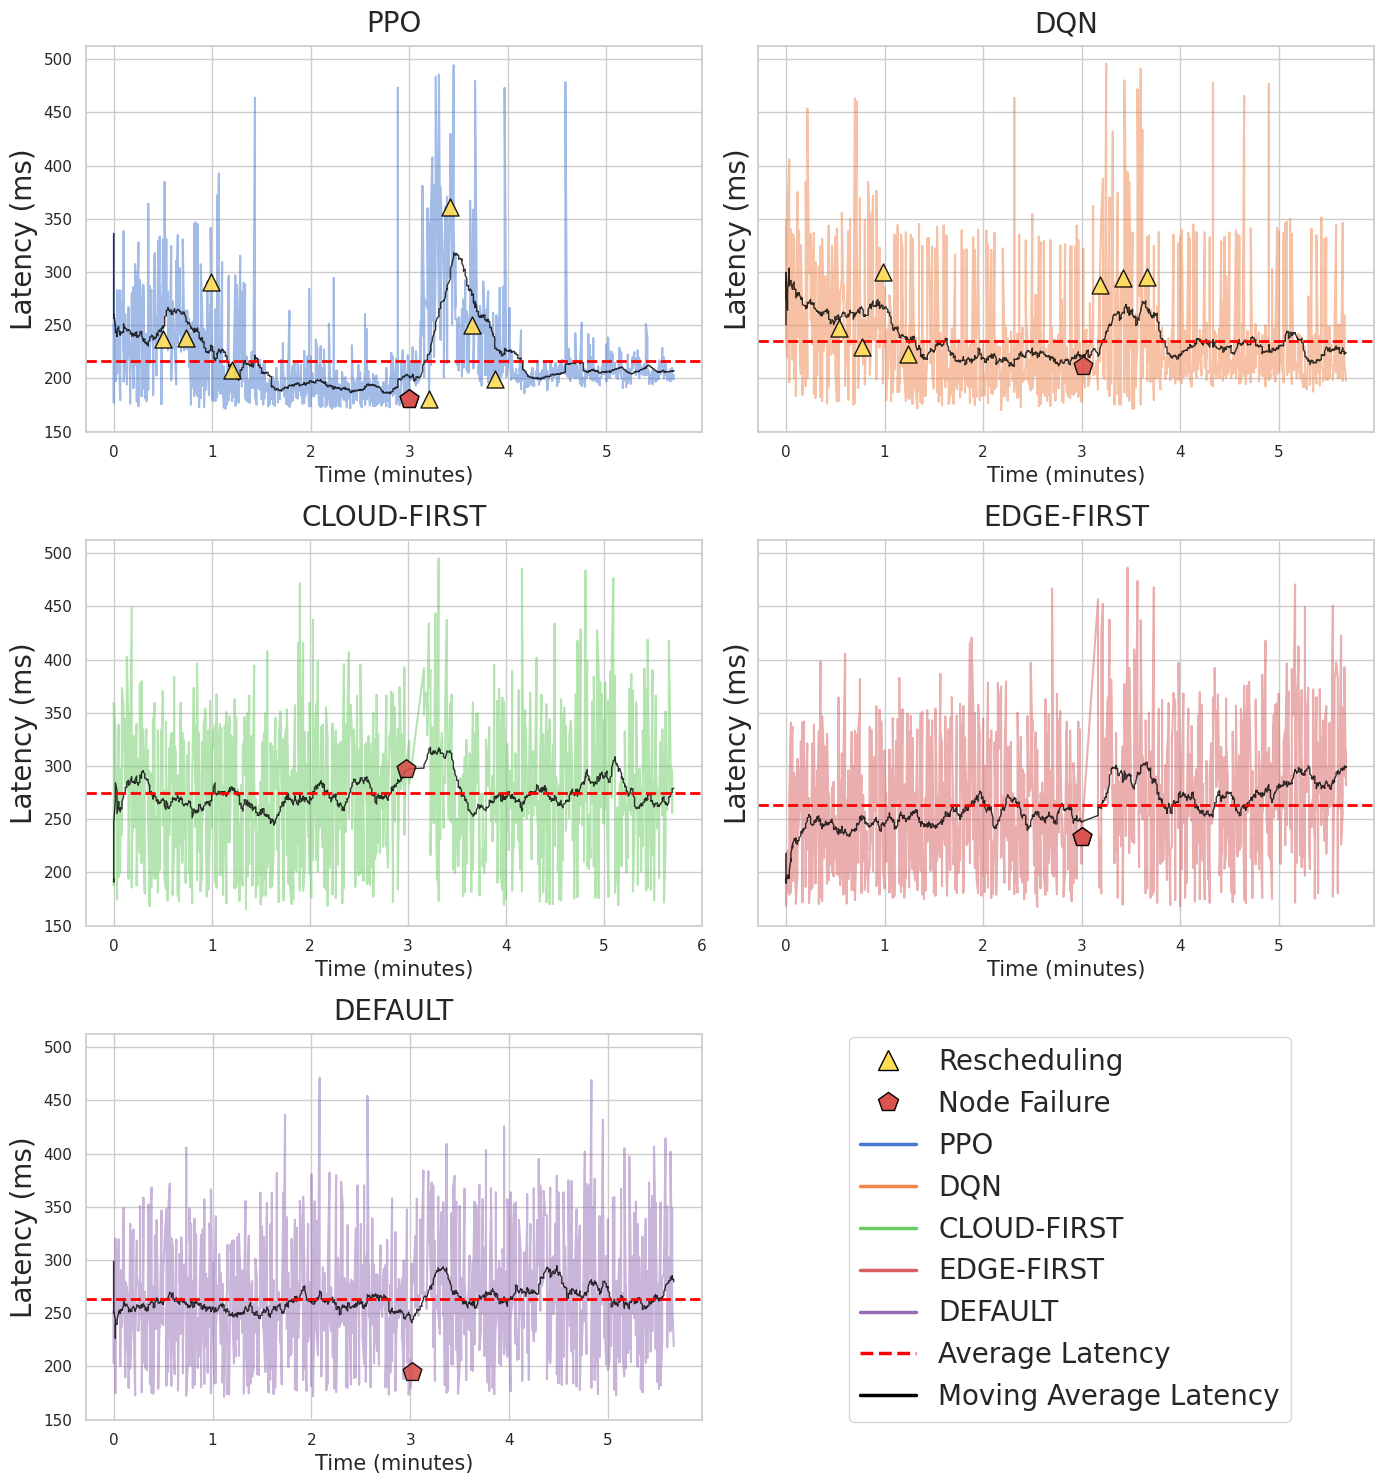

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置 Seaborn 主题
sns.set_theme(style="whitegrid")

# 定义 MSA 和策略列表
msa_list = ["aggregator_parallel", "aggregator_sequential", "chain"]
strategy_list = ["ppo", "dqn", "cloud", "edge", "all"]

# 是否为测试模式
isTest = False
testDataPath = "results/nodefailed/aggregator_parallel_ppo_replica3.csv"

# 生成 muted 调色板颜色
palette = sns.color_palette("muted", n_colors=5)

# 配色方案
reschedule_color = "#ffdd57"  # 亮黄色
node_failed_color = "#d9534f"  # 深橙红色
average_line_color = "#4d4d4d"  # 深灰色

# 逐个 MSA 绘制独立的图表
for msa in msa_list:
    # 创建一个大图，并根据策略数量创建子图 (3行2列)
    fig, axes = plt.subplots(3, 2, figsize=(14, 15), sharey=True)
    
    # 初始化列表来收集图例句柄和标签
    latency_handles = []
    latency_labels = []

    # 逐个策略读取数据并绘制在子图中
    for idx, strategy in enumerate(strategy_list):
        # 根据 idx 计算行列位置
        row = idx // 2
        col = idx % 2
        ax = axes[row][col]
        
        # 读取数据
        if isTest:
            data = pd.read_csv(testDataPath)
        else:
            # 假设数据保存在 '{msa}_{strategy}_replica3.csv' 文件中
            data_path = f"results/nodefailed/{msa}_{strategy}_replica3.csv"
            if not os.path.exists(data_path):
                print(f"文件未找到: {data_path}")
                continue
            data = pd.read_csv(data_path)
        
        if data.empty:
            print(f"{msa} - {strategy}: 数据为空，跳过。")
            continue
        
        # 将 timestamp 转换为 datetime 格式
        data['human_readable_timestamp'] = pd.to_datetime(data['human_readable_timestamp'], errors='coerce')
        data = data.dropna(subset=['human_readable_timestamp'])
        
        # 对数据按 timestamp 进行排序
        data = data.sort_values(by='human_readable_timestamp')
        
        # 找到第一个 'experiment_start' 的时间
        experiment_start_time = data[data['event'] == 'experiment_start']['human_readable_timestamp'].min()
        print(f"{msa} - {strategy}: Experiment Start Time:", experiment_start_time)
        
        # 丢弃 'experiment_start' 及之前的所有数据
        data = data[data['human_readable_timestamp'] > experiment_start_time]
        
        # 确保过滤掉任何不合理的值，例如负数或异常大的值 (optional)
        print(f"{msa} - {strategy}: 过滤前行数: {len(data)}")
        data = data[(data['latency'] >= 0) & (data['latency'] < 500)]
        print(f"{msa} - {strategy}: 过滤后行数: {len(data)}")
        
        if data.empty:
            print(f"{msa} - {strategy}: 过滤后数据为空，跳过。")
            continue
        
        # 以第一个时间点为基准，将时间转换为相对时间
        baseline_time = data['human_readable_timestamp'].min()  # 统一基准时间
        data['relative_time'] = (data['human_readable_timestamp'] - baseline_time).dt.total_seconds() / 60  # 转换为分钟
        
        # 移除非 latency 事件的数据点，但保留 'rescheduling' 和 'node_failed' 事件
        data.loc[data['event'].isin(['experiment_end', 'node_recovered']), 'latency'] = None
        
        # 计算移动平均 (窗口大小为10)
        data['latency_moving_avg'] = data['latency'].rolling(window=40, min_periods=1).mean()
        
        # 计算 latency 平均值并打印
        latency_mean = data['latency'].mean()
        print(f"{msa} - {strategy}: 平均 Latency = {latency_mean:.2f} ms")
        
        # 使用不同 muted 调色板颜色
        primary_color = palette[idx % len(palette)]

        # 绘制延迟折线图（不在图例中显示）
        ax.plot(data['relative_time'], data['latency'], 
                color=primary_color, linewidth=1.5, alpha=0.5)
        
        # 绘制移动平均线
        ax.plot(data['relative_time'], data['latency_moving_avg'], 
                color="black", linewidth=1, alpha=0.8)
        
        # 创建线段图标并添加到句柄列表
        line_handle = plt.Line2D([], [], color=primary_color, linewidth=2.5, label=f'{strategy.upper()}')
        latency_handles.append(line_handle)
        latency_labels.append(f'{strategy.upper()}')
        
        # 绘制 latency 平均线 (无标签)
        ax.axhline(latency_mean, color="red", linestyle='--', linewidth=2.0)
        
        # 筛选出 rescheduling 和 node_failed 事件
        reschedule_events = data[data['event'] == 'rescheduling']
        node_failed_events = data[data['event'] == 'node_failed']
        
        # 标记 rescheduling 事件
        ax.scatter(reschedule_events['relative_time'], reschedule_events['latency'], 
                   color=reschedule_color, label='Rescheduling', marker='^', s=150, edgecolor='black', alpha=0.9, zorder=5)
        
        # 标记 node_failed 事件
        ax.scatter(node_failed_events['relative_time'], node_failed_events['latency'], 
                   color=node_failed_color, label='Node Failed', marker='p', s=200, edgecolor='black', alpha=0.9, zorder=5)
        
        # 图形标注
        ax.set_xlabel("Time (minutes)", fontsize=15)
        ax.set_ylabel("Latency (ms)", fontsize=20)
        title_map = {
            "ppo": "PPO",
            "dqn": "DQN",
            "cloud": "CLOUD-FIRST",
            "edge": "EDGE-FIRST",
            "all": "DEFAULT"
        }
        ax.set_title(f"{title_map[strategy]}", fontsize=20, pad=10)

    # 隐藏未使用的子图（例如第6个子图）
    axes[2][1].set_visible(False)

    # 创建 rescheduling 和 node_failed 的句柄（仅需创建一次）
    rescheduling_handle = plt.Line2D([], [], color=reschedule_color, marker='^', linestyle='None', markersize=15, markeredgecolor='black', label='Rescheduling')
    node_failed_handle = plt.Line2D([], [], color=node_failed_color, marker='p', linestyle='None', markersize=15, markeredgecolor='black', label='Node Failed')
    average_line_handle = plt.Line2D([], [], color="red", linestyle='--', linewidth=2.5, label='Average Latency')
    moving_average_line_handle = plt.Line2D([], [], color="black", linestyle='-', linewidth=2.5, label='Moving Average')

    # 合并所有句柄和标签
    title_map = {
        "PPO": "PPO",
        "DQN": "DQN",
        "CLOUD": "CLOUD-FIRST",
        "EDGE": "EDGE-FIRST",
        "ALL": "DEFAULT"
    }
    legend_handles = [rescheduling_handle, node_failed_handle] + latency_handles + [average_line_handle, moving_average_line_handle]

    latency_labels = [title_map[label] for label in latency_labels]
    legend_labels = ['Rescheduling', 'Node Failure'] + latency_labels + ['Average Latency', 'Moving Average Latency']

    # 在主图中添加图例
    fig.legend(legend_handles, legend_labels, fontsize=20, ncol=1, loc='center', bbox_to_anchor=(0.77, 0.175))

    # 增加全图的标题
    # fig.suptitle(f"Latency{msa}", fontsize=25, y=1.02)

    # 调整图形布局
    plt.tight_layout()

    # 如果需要保存图表，可以取消下面的注释
    plt.savefig(f"output/timeseries/latency_{msa}.png", dpi=300, bbox_inches='tight')

    # 显示图表
    plt.show()


aggregator_parallel - ppo: Experiment Start Time: 2024-10-25 05:06:47
aggregator_parallel - ppo: 过滤前行数: 1366
aggregator_parallel - ppo: 过滤后行数: 1362
aggregator_parallel - dqn: Experiment Start Time: 2024-10-25 05:14:15
aggregator_parallel - dqn: 过滤前行数: 1219
aggregator_parallel - dqn: 过滤后行数: 1215
aggregator_parallel - cloud: Experiment Start Time: 2024-10-25 06:06:56
aggregator_parallel - cloud: 过滤前行数: 1211
aggregator_parallel - cloud: 过滤后行数: 1206
aggregator_parallel - edge: Experiment Start Time: 2024-10-25 06:14:15
aggregator_parallel - edge: 过滤前行数: 1204
aggregator_parallel - edge: 过滤后行数: 1204
aggregator_parallel - all: Experiment Start Time: 2024-10-25 05:59:37
aggregator_parallel - all: 过滤前行数: 1197
aggregator_parallel - all: 过滤后行数: 1195
aggregator_sequential - ppo: Experiment Start Time: 2024-10-25 05:36:41
aggregator_sequential - ppo: 过滤前行数: 1168
aggregator_sequential - ppo: 过滤后行数: 1164
aggregator_sequential - dqn: Experiment Start Time: 2024-10-25 05:44:11
aggregator_sequential - d

/tmp/ipykernel_3497083/2320535733.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='Proportion', data=msa_df, palette="muted")


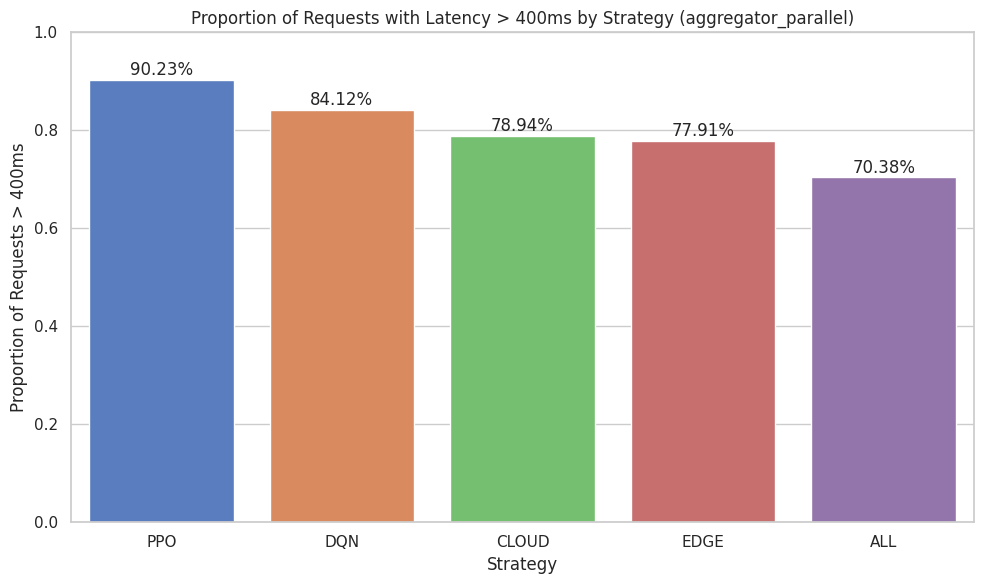


MSA: aggregator_sequential
  Strategy  Exceeded 400ms  Total Requests  Proportion
0      PPO             989            1164    0.849656
1      DQN             716            1111    0.644464
2    CLOUD             465            1031    0.451018
3     EDGE             434            1013    0.428430
4      ALL             411            1026    0.400585


/tmp/ipykernel_3497083/2320535733.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='Proportion', data=msa_df, palette="muted")


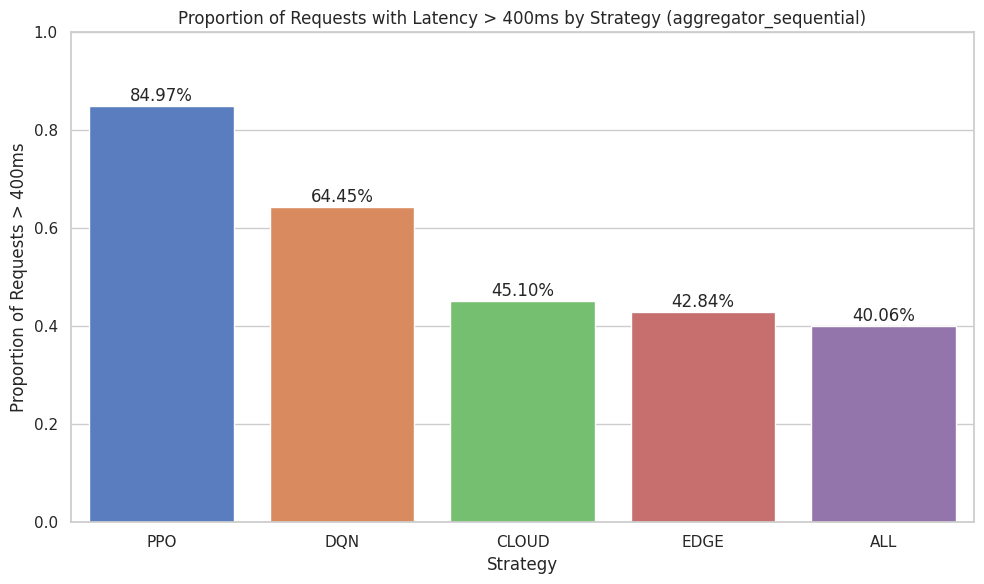


MSA: chain
  Strategy  Exceeded 400ms  Total Requests  Proportion
0      PPO            1048            1233    0.849959
1      DQN             883            1148    0.769164
2    CLOUD             352             991    0.355197
3     EDGE             479            1036    0.462355
4      ALL             440            1054    0.417457


/tmp/ipykernel_3497083/2320535733.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Strategy', y='Proportion', data=msa_df, palette="muted")


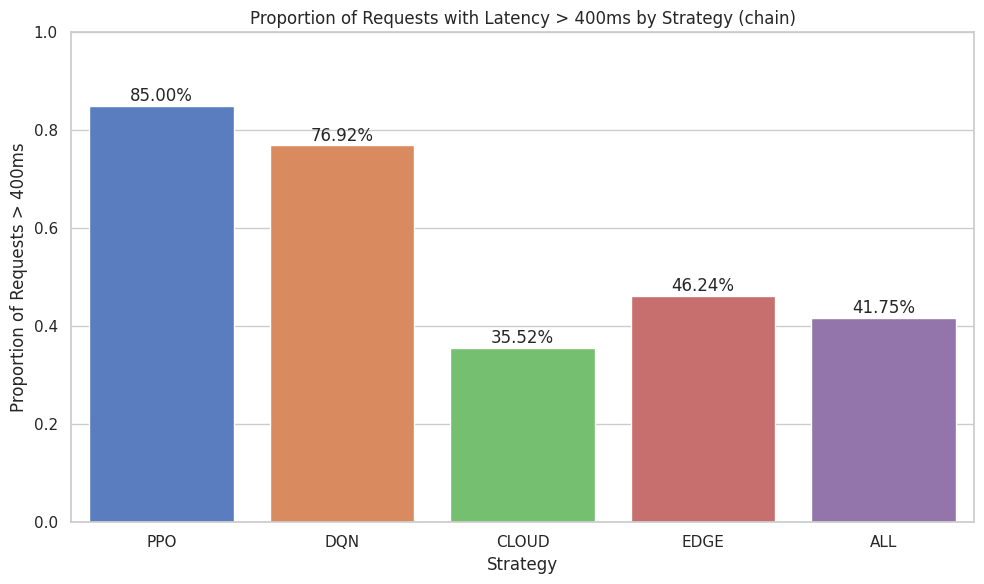

/tmp/ipykernel_3497083/2320535733.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


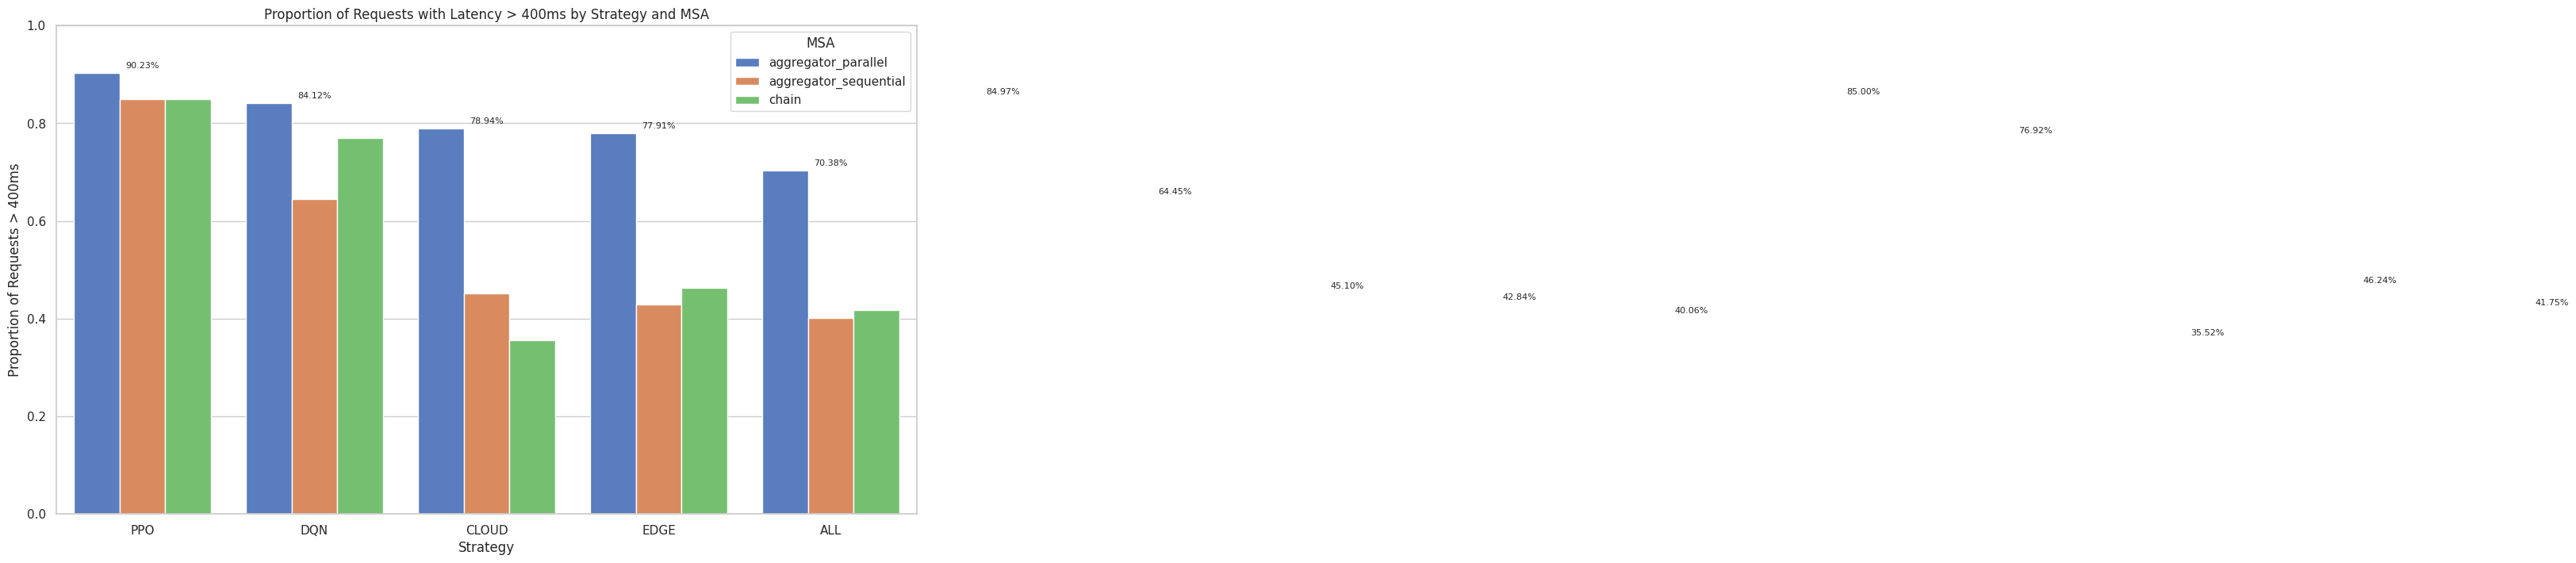

In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 主题
sns.set_theme(style="whitegrid")

# 定义 MSA 和策略列表
msa_list = ["aggregator_parallel", "aggregator_sequential", "chain"]
strategy_list = ["ppo", "dqn", "cloud", "edge", "all"]

# 是否为测试模式
isTest = False
testDataPath = "results/nodefailed/aggregator_parallel_ppo_replica3.csv"

# 初始化一个字典来存储结果，按MSA和策略分类
results = {msa: {strategy: {'exceeded': 0, 'total': 0} for strategy in strategy_list} for msa in msa_list}

# 逐个 MSA 和策略读取数据并计算比例
for msa in msa_list:
    for strategy in strategy_list:
        # 读取数据
        if isTest:
            data = pd.read_csv(testDataPath)
        else:
            # 假设数据保存在 'results/nodefailed/{msa}_{strategy}_replica3.csv' 文件中
            data_path = f"results/nodefailed/{msa}_{strategy}_replica3.csv"
            if not os.path.exists(data_path):
                print(f"文件未找到: {data_path}")
                continue
            data = pd.read_csv(data_path)
        
        if data.empty:
            print(f"{msa} - {strategy}: 数据为空，跳过。")
            continue
        
        # 将 timestamp 转换为 datetime 格式
        data['human_readable_timestamp'] = pd.to_datetime(data['human_readable_timestamp'], errors='coerce')
        data = data.dropna(subset=['human_readable_timestamp'])
        
        # 对数据按 timestamp 进行排序
        data = data.sort_values(by='human_readable_timestamp')
        
        # 找到第一个 'experiment_start' 的时间
        experiment_start_time = data[data['event'] == 'experiment_start']['human_readable_timestamp'].min()
        print(f"{msa} - {strategy}: Experiment Start Time:", experiment_start_time)
        
        # 丢弃 'experiment_start' 及之前的所有数据
        data = data[data['human_readable_timestamp'] > experiment_start_time]
        
        # 过滤延迟值
        print(f"{msa} - {strategy}: 过滤前行数: {len(data)}")
        data = data[(data['latency'] >= 0) & (data['latency'] < 500)]
        print(f"{msa} - {strategy}: 过滤后行数: {len(data)}")
        
        if data.empty:
            print(f"{msa} - {strategy}: 过滤后数据为空，跳过。")
            continue
        
        # 计算延迟超过400ms的数量和总数
        exceeded_count = (data['latency'] < 250).sum()
        total_count = len(data)
        
        # 存储到结果字典中
        results[msa][strategy]['exceeded'] += exceeded_count
        results[msa][strategy]['total'] += total_count

# 创建一个列表来存储所有结果
ratio_data = []
for msa in msa_list:
    for strategy in strategy_list:
        exceeded = results[msa][strategy]['exceeded']
        total = results[msa][strategy]['total']
        if total > 0:
            proportion = exceeded / total
        else:
            proportion = None
        ratio_data.append({
            'MSA': msa,
            'Strategy': strategy.upper(),
            'Exceeded 400ms': exceeded,
            'Total Requests': total,
            'Proportion': proportion
        })

# 创建结果DataFrame
ratio_df = pd.DataFrame(ratio_data)

# 分别为每个MSA创建单独的DataFrame
for msa in msa_list:
    msa_df = ratio_df[ratio_df['MSA'] == msa].reset_index(drop=True)
    print(f"\nMSA: {msa}")
    print(msa_df[['Strategy', 'Exceeded 400ms', 'Total Requests', 'Proportion']])
    
    # 保存为CSV文件
    msa_df.to_csv(f"latency_exceeded_ratio_{msa}.csv", index=False)
    
    # 可视化
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Strategy', y='Proportion', data=msa_df, palette="muted")
    plt.ylabel('Proportion of Requests > 400ms')
    plt.xlabel('Strategy')
    plt.title(f'Proportion of Requests with Latency > 400ms by Strategy ({msa})')
    plt.ylim(0, 1)  # 0% 到 100%
    
    # 在每个柱上添加百分比标签
    for index, row in msa_df.iterrows():
        if row['Proportion'] is not None:
            plt.text(index, row['Proportion'] + 0.01, f"{row['Proportion']*100:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.savefig(f"latency_exceeded_ratio_{msa}.png", dpi=300)
    plt.show()

# 如果需要，可以将所有结果保存为一个综合的CSV文件
ratio_df.to_csv("latency_exceeded_ratio_all_msas.csv", index=False)

# 可选：绘制综合柱状图，按MSA和策略展示
plt.figure(figsize=(14, 8))
sns.barplot(x='Strategy', y='Proportion', hue='MSA', data=ratio_df, palette="muted")
plt.ylabel('Proportion of Requests > 400ms')
plt.xlabel('Strategy')
plt.title('Proportion of Requests with Latency > 400ms by Strategy and MSA')
plt.ylim(0, 1)  # 0% 到 100%
# 在每个柱上添加百分比标签
for index, row in ratio_df.iterrows():
    if row['Proportion'] is not None:
        plt.text(row.name, row['Proportion'] + 0.01, f"{row['Proportion']*100:.2f}%", ha='center', fontsize=8)
plt.legend(title='MSA')
plt.tight_layout()
plt.savefig("latency_exceeded_ratio_combined.png", dpi=300)
plt.show()
